# Datascience Miniproject for Kokoon
#### By Daniel Leirer

## Table of Contents

<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#set&lib">Settings and Libraries</a></li>
<li><a href="#data_exp">Data Exploration: Model 1</a></li>
<li><a href="#init_mod">Model 1</a></li>

</ul>


<a id='intro'></a>

## Introduction:

This project aims to predict the sale price of houses, the outcome messure is RSME. 

My approach for this will be as follows. 
1. Data exploration and visualisation:
    1. Check for missing values, obvious outliers and variables that may need to be discarded. 
    2. Create dummy variables for categoricals if necessary. 
    3. Visualise variables looking at distribution, correlation and variance. 

2. Initial model building:
    1. I will focus on Random Forest, since there are a lot of features. Random Forest is relatively roboust to data that is not necessairly normally distributed. 

3. Look at most important features, think about feature engineering and feature reduction:
    1. potentially use Recursive Feature Elimination (RFE) if there is time. 

<a id="set&lib"></a>
    
## Settings & Libraries:


### Import Packages:

In [156]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



from math import sqrt

import sklearn
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

#magic for matplotlib
%matplotlib inline

### Get Data:


In [2]:
#data directory
data_dir = "data"
#make paths
train_path = os.path.join(data_dir,"train.csv")
test_path = os.path.join(data_dir,"test.csv")

#load data
df_train = pd.read_csv(train_path,sep=",")
df_test = pd.read_csv(test_path, sep=",")




### Split train data to train and validation datasets:
This should really be done prior to any data exploration. The reason is that by exploring the data we are building hypothesies on a sample of the population that may not translate to the population in general. By creating a validation dataset very early on we reduce the chance of introducting a systematic bias when exploring the data. `

In [3]:
seed = 7
#create training and validation data
X_train, X_validate, Y_train, Y_validate = train_test_split(
    df_train.drop(columns=["SalePrice"]), df_train["SalePrice"], random_state= seed)

<a id="data_exp"></a>

## Data Exploration: (Model 1)

In [4]:
print("Training data shape ", X_train.shape)
print("Validation data shape ",X_validate.shape)
print("Validation data shape ",df_test.shape)

Training data shape  (1095, 80)
Validation data shape  (365, 80)
Validation data shape  (1459, 80)


In [21]:
#X_train.info()
#X_train.describe()

### Create dummy variables for all categorical features:
1. First create dummy variables for categorical features. This creates a new binary column for each category. 
2. Create correlation matrix. 
3. Find features that are highly correlated with price. 

In [97]:
#create dataframe for exploration. 
df_explore=X_train.copy() 
#add sale price back in. 
df_explore["SalePrice_log"] = np.log(Y_train)

#create dummy variables for all features. 
df_dummies = pd.get_dummies(df_explore)

#make correlation matrix
corrMatrix_full = df_dummies.corr()
#subset correlation matrix to absulute corelation above 0.5 with log of SalePrice
sale_price_corr= corrMatrix_full.SalePrice_log[abs(corrMatrix_full.SalePrice_log) > 0.5]

#get list of important columns
col_list_sp = sale_price_corr.index.tolist()
### Quick reorder to make Saleprice_log more obvious
col_list_sp =['SalePrice_log',
              'OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'ExterQual_Gd',
 'ExterQual_TA',
 'Foundation_PConc',
 'KitchenQual_TA']

#make correlation matrix for plotting heatmap. This is subset to columns above.
corrMatrix_sp =  df_dummies[col_list_sp].corr()

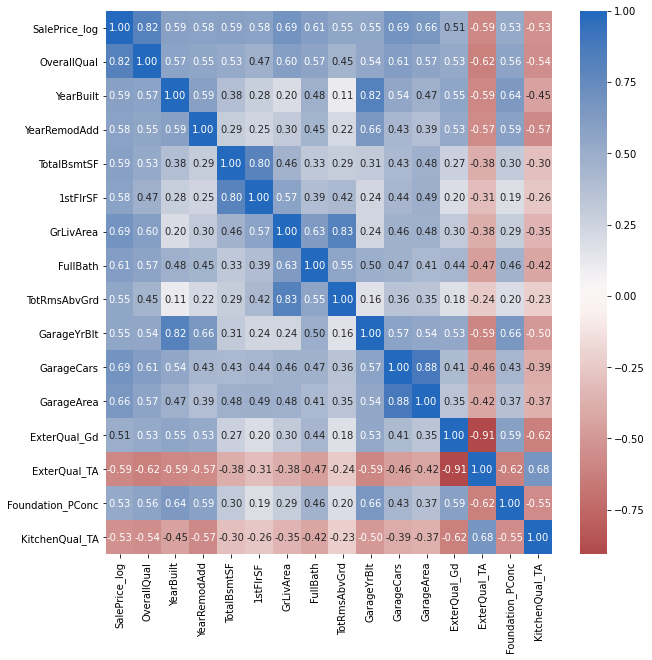

In [98]:
#plot heatmap of features correlated with sale price
plt.figure(figsize = [10,10])

#ht =sns.clustermap(corrMatrix_gender, annot = True)
ht = sns.heatmap(corrMatrix_sp, annot = True,cmap = 'vlag_r',fmt = '.2f',center = 0)
#ht.set_ylim(len(corrMatrix_sp)+0.5, -0.5)

The above heatmap shows the features that have a correlation above 0.5 with Saleprice. 
5 Features have a correlation above 0.6 these are OverallQual, GrLivArea, Full Bath, GarageCars and Garage Area. 

What strikes me instantly is overal quality which seems to be the most important feature. This makes a lot of sense.

We also see Square foot of basement (TotalbsmtSF), and first floor(1stflrSF), allthough those two values are highly correlated anyway. GrLivArea is also liekly to be important and makes sense. 

Interestingly there is a higher correlation with GarageCars and GarageArea. I am assuming that Houses with multiple spaces for cars are going to be overall larger and more expensive. 


These features seem to make sense, as a starting point. 


An interesting feature is year since remodelling added. 
It might be interesting to create a feature that combines year of remodeling added with year sold.

## Preprocessing Steps: (Model 1)
Preprocessing for first model. 

In [93]:
#log transform for price. 
Y_train_log = np.log(Y_train)
Y_validate_log = np.log(Y_validate)
#Add dummies. 
X_train_dummies = pd.get_dummies(X_train)
X_validate_dummies = pd.get_dummies(X_validate)

In [113]:
#Features for initial model. 
model_1_features = ['OverallQual','GrLivArea','FullBath','1stFlrSF','TotalBsmtSF','GarageCars','GarageArea','YearBuilt','YearRemodAdd','TotRmsAbvGrd','GarageYrBlt','ExterQual_Gd','ExterQual_TA','Foundation_PConc','KitchenQual_TA']

#check df info.
X_train_dummies[model_1_features].info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1095 entries, 895 to 175
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   OverallQual       1095 non-null   int64  
 1   GrLivArea         1095 non-null   int64  
 2   FullBath          1095 non-null   int64  
 3   1stFlrSF          1095 non-null   int64  
 4   TotalBsmtSF       1095 non-null   int64  
 5   GarageCars        1095 non-null   int64  
 6   GarageArea        1095 non-null   int64  
 7   YearBuilt         1095 non-null   int64  
 8   YearRemodAdd      1095 non-null   int64  
 9   TotRmsAbvGrd      1095 non-null   int64  
 10  GarageYrBlt       1029 non-null   float64
 11  ExterQual_Gd      1095 non-null   uint8  
 12  ExterQual_TA      1095 non-null   uint8  
 13  Foundation_PConc  1095 non-null   uint8  
 14  KitchenQual_TA    1095 non-null   uint8  
dtypes: float64(1), int64(10), uint8(4)
memory usage: 106.9 KB


It looks like there are some missing values for Garage year built.
Will remove for now, but might be worth imputing values later. 

<a id="init_mod"></a>

## Model 1:

In [148]:
#Features for initial model. 
model_1_features = ['OverallQual','GrLivArea','FullBath','1stFlrSF','YearBuilt','YearRemodAdd','TotRmsAbvGrd','ExterQual_Gd','ExterQual_TA','Foundation_PConc','KitchenQual_TA']


#setting for random forrest
RF_model = RandomForestRegressor(max_depth=2, random_state=0)

#fit model
RF_model.fit(X_train_dummies[model_1_features], Y_train_log)



RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=2, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

Model 1 R^2 0.6762551668732087
Model 1 RSME =  0.2309727486981749


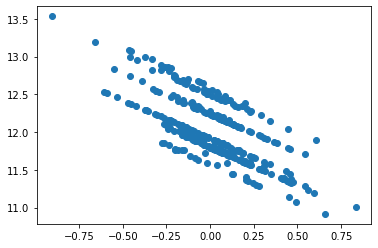

In [175]:
#get results
Results = RF_model.predict(X_validate_dummies[model_1_features])

#create df that includes results
df_validate_results = pd.DataFrame({"Id" : Y_validate.index ,"SalePrice_real" : Y_validate_log, "SalePrice_predicted" : Results})

#calculate error. 
df_validate_results["Error"] = df_validate_results.SalePrice_predicted - df_validate_results.SalePrice_real 

#get RSME
model_1_RSME = sqrt(mean_squared_error(df_validate_results.SalePrice_real, df_validate_results.SalePrice_predicted))
Rsquared= r2_score(df_validate_results["SalePrice_real"], df_validate_results["SalePrice_predicted"])
print("Model 1 R^2",Rsquared)
print("Model 1 RSME = ",model_1_RSME)

#plot error
plt.scatter(df_validate_results["Error"],df_validate_results["SalePrice_real"])

The modeling above should really include a k-fold cross validation step and exploration of hyperparameters.
But was unable to implement that. 

The Rsquared was 0.676
The RSME was 0.231

Plotting the Error (predicted - real price) we can see that model right now tends to systematically get prices wrong. 
The predictions of the model tend to become worse the further away prices are from the median. 

## Create output file:


In [150]:
## Preprocess for output
df_test_dummies = pd.get_dummies(df_test)

df_test_dummies[model_1_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   OverallQual       1459 non-null   int64
 1   GrLivArea         1459 non-null   int64
 2   FullBath          1459 non-null   int64
 3   1stFlrSF          1459 non-null   int64
 4   YearBuilt         1459 non-null   int64
 5   YearRemodAdd      1459 non-null   int64
 6   TotRmsAbvGrd      1459 non-null   int64
 7   ExterQual_Gd      1459 non-null   uint8
 8   ExterQual_TA      1459 non-null   uint8
 9   Foundation_PConc  1459 non-null   uint8
 10  KitchenQual_TA    1459 non-null   uint8
dtypes: int64(7), uint8(4)
memory usage: 85.6 KB


In [151]:
#get results
test_results = RF_model.predict(df_test_dummies[model_1_features],)

#create df for test output
df_submission_file = pd.DataFrame({"Id" : df_test.index ,"SalePrice" : np.exp(test_results)})

#create path for file
submission_path = os.path.join(data_dir,"submission.csv")
#write to csv
df_submission_file.to_csv(submission_path, index=False,sep=",")